In [405]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
import scipy.stats as st
import numpy.linalg as la
from tqdm import tqdm

In [9]:
from clusterization import vbgmm
reload(vbgmm)

<module 'clusterization.vbgmm' from 'clusterization/vbgmm.py'>

In [3]:
data = pd.read_pickle('data/work_catalog_rtl')

In [4]:
data.head(n=5)

,lat,long,depth,class,date_time,diff_in_days_before_first_eqarthquake,l_r
0,12.2734,20.5460,8.0,2.9,1990-01-01 02:19:05,0.000000,0.704688
1,9.9358,18.2461,30.6,3.0,1990-01-01 04:04:20,0.073090,0.740818
2,6.7053,16.9990,18.6,2.7,1990-01-01 07:14:11,0.204931,0.637628
3,6.4859,16.3964,67.2,4.3,1990-01-01 09:03:12,0.280637,1.419068
4,5.0121,13.8440,22.6,2.5,1990-01-01 12:31:25,0.425231,0.576950


# Train clusters

In [291]:
train_idx = pd.DatetimeIndex(data['date_time']).year < 1995
test_idx = pd.DatetimeIndex(data['date_time']).year >= 1995
data_train = data[train_idx]
data_test = data[test_idx]

In [294]:
def ClusterOnMonthData(month,threshold, dataset, max_iter):
    month_idx = pd.DatetimeIndex(dataset['date_time']).month == month
    make_cluster_data = dataset[month_idx]
    make_cluster_data = make_cluster_data[make_cluster_data['class'] > threshold]
    X = make_cluster_data[['lat', 'long']]
    X = X.values
    
    # cluster init
    max_cluster_number = 10
    m_0 = np.zeros(2)
    mu_0 = 1.
    b_0 = 1.
    inv_W_0 = 0.01 * np.identity(2)
    alpha_0 = np.array([1.1] * max_cluster_number) 
    m_k = X[np.random.randint(X.shape[0], size=max_cluster_number)]
    b_k = np.array([1.] * max_cluster_number)
    W_k = np.repeat(np.identity(2)[None,:,:], max_cluster_number, axis=0)
    mu_k = np.array([1.] * max_cluster_number)
    alpha_k = np.array([1.1] * max_cluster_number) 
    R_k = np.repeat(np.array([1. / max_cluster_number] * max_cluster_number)[None,:], X.shape[0], axis=0)
    
    #clustering
    kmeans = KMeans(n_clusters=max_cluster_number, random_state=0, init='random').fit(X)
    #plt.figure(figsize=[3,4])
    #plt.scatter(X[:,0], X[:,1], c=kmeans.labels_);
    
    m_k = kmeans.cluster_centers_
    gmm = vbgmm.VBGMM(X, m_0, b_0, inv_W_0, mu_0, alpha_0, m_k, b_k, W_k, mu_k, alpha_k, R_k)
    gmm.VariationalUpdates(max_iter)
    
    
    plt.figure(figsize=[3,4])
    plt.scatter(X[:,0], X[:,1], c=np.argmax(gmm.R_k, axis=1));
    
    return gmm

0 0 0 0 0 0 0 0 0 0 0 0


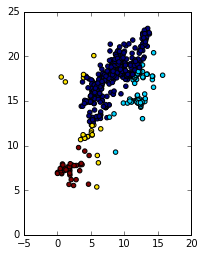

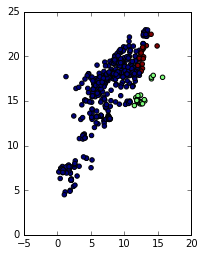

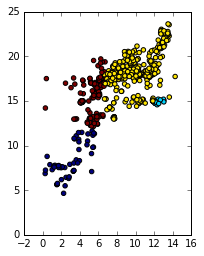

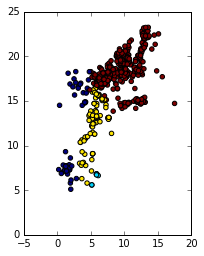

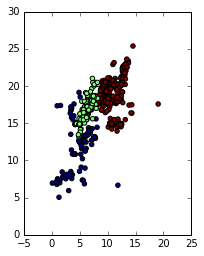

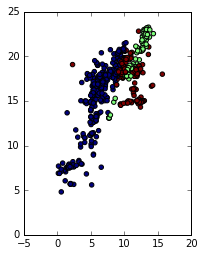

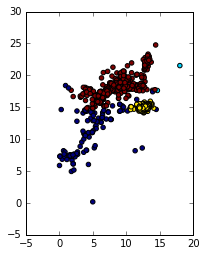

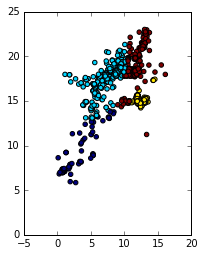

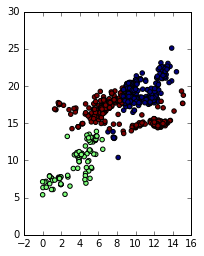

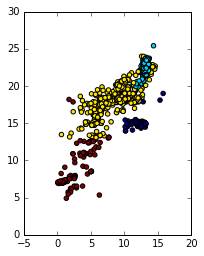

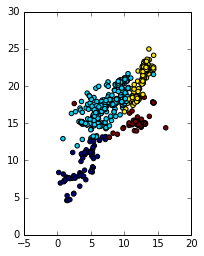

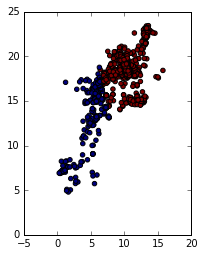

In [297]:
gmm_month_models = []
k = 0
for i in range(12):
    k = i + 1
    gmm_month_models.append(ClusterOnMonthData(month=k, threshold=3., dataset=data_train, max_iter=5))

In [310]:
def ClosestClusterMahanalubis(gmm, point):
    center = gmm.m_k
    cov = gmm_month_models[0].W_k * gmm_month_models[0].mu_k[:,None,None]
    prob = [st.multivariate_normal.pdf(point, center[k,:], cov[k,:,:])  for k in range(center.shape[0])]
    return np.argmax(np.array(prob))

In [323]:
for k in range(12):
    num_cluster = []
    for i in range(data_test.shape[0]):
        if i % 1000 == 0:
            print(int(i / 1000.)),
        result = ClosestClusterMahanalubis(gmm_month_models[k], point=data_test[['lat', 'long']].iloc[i,:])
        num_cluster.append(result)
    data_test['cluster_' + str(k)] = num_cluster

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 0

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 

In [325]:
data_test.head(n=5)

,lat,long,depth,class,date_time,diff_in_days_before_first_eqarthquake,l_r,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11
30189,10.9693,15.1221,31.0,3.0,1995-01-01 00:32:17,1825.925833,0.740818,6,8,7,9,9,9,8,8,9,6,9,9
30190,9.8749,19.1175,0.0,3.5,1995-01-01 00:33:54,1825.926956,0.951229,6,9,8,9,9,9,9,9,7,8,9,9
30191,11.5361,16.9342,19.0,3.1,1995-01-01 00:42:16,1825.932766,0.778801,7,9,8,9,9,9,9,9,9,6,9,9
30192,10.4968,18.0257,19.6,3.2,1995-01-01 01:01:54,1825.946400,0.818731,7,9,8,9,9,9,9,9,7,8,9,9
30193,10.2800,19.5600,34.0,3.1,1995-01-01 01:06:44,1825.949757,0.778801,6,9,8,9,9,8,9,9,7,6,9,9


In [351]:
np.unique(data_test['cluster_11'].values)

array([0, 8, 9])

# RTL series in cluster

In [337]:
data_test.columns[7], data_test.columns[18]

('cluster_0', 'cluster_11')

In [406]:
def RTL_in_glm_K_clusters(dataset, k, r0, t0):
    cluster_labels = np.unique(dataset.iloc[:,k])
    cluster_rtl = []
    for label in cluster_labels:
        data_frame = dataset[dataset.iloc[:,k] == label]
        r, t, l, zero_r, zero_t, zero_l = [], [], [], [], [], []
        for idx, x in tqdm(data_frame.iterrows()):
            if idx != 0:
                points_before_x = (data_frame.iloc[:idx, :]).copy()
                points_before_x['time_delta'] = x['diff_in_days_before_first_eqarthquake'] - points_before_x['diff_in_days_before_first_eqarthquake'] + 1e-3
                distance = points_before_x[['lat', 'long']].values - x[['lat', 'long']].values
                points_before_x['distance'] = 100. * np.array([np.linalg.norm(distance[i,:]) for i in range(points_before_x.shape[0])]) + 1e-3
                points_rtl = (points_before_x.loc[(points_before_x['distance'] < 2.*r0)\
                                          & (points_before_x['time_delta'] < 2.*t0)]).copy()
                if points_rtl.shape[0] == 0:
                    r.append(0.0)
                    t.append(0.0)
                    l.append(0.0)
                else:
                    r_x = np.sum(np.exp(-1.0 * points_rtl['distance'].values / r0))
                    t_x = np.sum(np.exp(-1.0 * points_rtl['time_delta'].values / t0))
                    l_x = np.sum(points_rtl['l_r'].values / points_rtl['distance'].values)

                    if np.isinf(l_x):
                        print('UVAGA! VOLK YNES ZAYCHAT!')
                        return r_x, t_x, l_x, idx, points_rtl

                    r.append(r_x)
                    t.append(t_x)
                    l.append(l_x)
        cluster_rtl.append([np.array([0] + r), np.array([0] + t), np.array([0] + l)])
    return cluster_rtl

In [ ]:
r0 = 100
t0 = 91

cluster_0_RTL = RTL_in_glm_K_clusters(data_test, 7, r0, t0)

89it [00:00, 359.09it/s]
792it [01:22,  9.21it/s]